# Develop Cloudsat/ERA visualizations

In [5]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon, Point, box
import datetime


data_path1 = os.path.join('/Users/Lucien/Desktop/cloudsat_files')
data_path2 = os.path.join('/','Users','Lucien','Documents','cloudsat_project','data')
default_crs = 'epsg:3995'

## Read CloudSat data

Such a good tutorial: https://www.science-emergence.com/Articles/How-to-read-CloudSat-2B-GEOPROF-GRANULE-HDF4-file-using-python-and-pyhdf-/

In [8]:
from pyhdf.SD import SD, SDC
from pyhdf.HDF import *
from pyhdf.VS import *

def read_cloudsat_file(FILENAME): 
    """Reads an entire CloudSat file (HDF-EOS format)"""
    
    def read_datasets(FILENAME): 
        """Reads all datasets in the file, places fill_values with NaNs, and places in dictionary."""
        # Open the file
        file = SD(FILENAME, SDC.READ)
        datasets_dict = file.datasets()
        dataset_names = [dname for dname in datasets_dict.keys()]

        # Extract a single dataset from the file, replace the fill values with NaN. 
        data_dict = {}
        for ds in dataset_names: 
            sds_obj = file.select(ds) 
            data = sds_obj.get() 
            fill_val = sds_obj.attributes().get('_FillValue')
            if fill_val: 
                data = data.astype(np.float32)
                data[data==fill_val] = np.NaN
            data_dict[ds] = data

        return data_dict
    
    
    def read_vdata(FILENAME): 
        """Reads all vdata fields in the file and places in dictionary."""
        # Prepare to read the data. 
        f = HDF(FILENAME, SDC.READ)        # Open the file
        vs = f.vstart()                    # Start the vdata interface
        data_info_list = vs.vdatainfo()    # List the vdata fields
        vdata_fieldnames = [a[0] for a in data_info_list]    # Get the names
        
        # Load the data, place in dictionary
        vdata_dict = {}     
        for field in vdata_fieldnames: 
            vdata_dict[field] = np.squeeze(np.asarray(vs.attach(field)[:]))
        
        # terminate the vdata interface, close the file. 
        vs.end() 
        f.close()

        return vdata_dict
    
    def add_datetime(vdata_dict):
        """Adds a datetime vector (for time of each measurement) to the vdata_dict"""
        first_second = np.around(vdata_dict['UTC_start'],decimals=-2)
        first_dtime  = np.asarray(datetime.datetime.strptime(filename.split('/')[-1][:13],'%Y%j%H%M%S'))\
                                 .astype('datetime64[D]')+pd.Timedelta(str(first_second)+' seconds')
        tv = first_dtime+(np.around(vdata_dict['Profile_time'],decimals=2)*pd.Timedelta('1 seconds'))
        time_vec = np.asarray([pd.Timestamp(t) for t in tv])
        vdata_dict['datetime'] = time_vec
        return vdata_dict

    data_dict = read_datasets(FILENAME)
    vdata_dict = read_vdata(FILENAME)
    vdata_dict = add_datetime(vdata_dict)
      
    return data_dict,vdata_dict


class radarPass: 
    """Class for the radar pass... will hold all the relevant data!"""
    
    def __init__(self,lon,lat,timestamp,height,radar_refl,cpr_cloud_mask):
        
        # Data for the full pass
        self.lon_full = lon
        self.lat_full = lat
        self.timestamp_full = timestamp
        self.radar_refl_full = radar_refl
        self.cpr_cloud_mask_full = cpr_cloud_mask
        self.height = height
        
        # Data for trimmed pass
        self.lon = lon
        self.lat = lat
        self.timestamp = timestamp
        self.radar_refl = radar_refl
        self.cpr_cloud_mask = cpr_cloud_mask
        
    def trim_pass(self,inds_to_keep): 
        self.lon = self.lon_full[inds_to_keep]
        self.lat = self.lat_full[inds_to_keep]
        self.timestamp = self.timestamp_full[inds_to_keep]
        self.radar_refl = self.radar_refl_full[:,inds_to_keep]
        self.cpr_cloud_mask = self.cpr_cloud_mask_full[:,inds_to_keep]
        return self

In [9]:
filename = os.path.join(data_path2,'cloudsat_files',
                        '2015244020212_49703_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf')
data_dict,vdata_dict = read_cloudsat_file(filename)
radar_pass = radarPass(vdata_dict['Longitude'],vdata_dict['Latitude'],
                       vdata_dict['datetime'],np.ravel(data_dict['Height'][0,::-1]),
                       np.flipud(data_dict['Radar_Reflectivity'].T),
                       np.flipud(data_dict['CPR_Cloud_mask'].T))

/Users/Lucien/anaconda/envs/flux-tailor/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(735842.1319444445, 735842.1388888889)

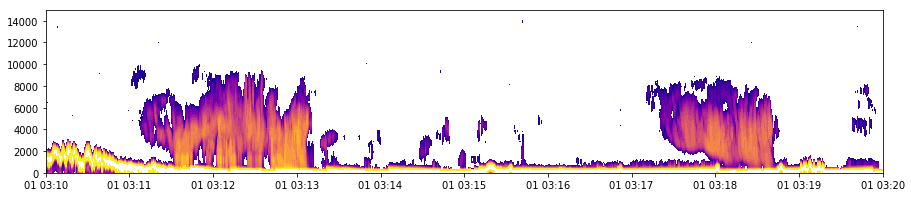

In [10]:
fig = plt.figure(figsize=[15,3])
#plt.imshow(data_dict['Radar_Reflectivity'].T)
plt.contourf(vdata_dict['datetime'],data_dict['Height'][0,:],data_dict['Radar_Reflectivity'].T,
             levels=np.linspace(-2300,2000,20),cmap=plt.get_cmap('plasma'))
plt.ylim([0,15000])
plt.xlim(['2015-09-01 03:10','2015-09-01 03:20'])

## Develop the plot

In [434]:
def specify_area_of_interest_EPSG4326(bbox=(-180,60,180,90)): 
    area_of_int = gpd.GeoDataFrame({'geometry':[box(*bbox)]})
    area_of_int.crs = {'init':'epsg:4326'}
    return area_of_int

def specify_area_of_interest_EPSG3995(bbox=(-3e6,-3e6,3e6,3e6)): 
    area_of_int = gpd.GeoDataFrame({'geometry':[box(*bbox)]})
    area_of_int.crs = {'init':default_crs}
    return area_of_int

def get_country_geometries(area_of_interest):
    countries = gpd.read_file(os.path.join(data_path2,'Countries_WGS84','Countries_WGS84.shp'))
    countries = countries.to_crs({'init':default_crs})
    countries = gpd.overlay(countries,area_of_interest,how='intersection')
    return countries

def prepare_coords_for_bokeh(countries): 
    """Need to go from a list of points to two lists of lists (one for x and y coordinates). 
    For each list of lists, the inner lists contain the x or y coordinates for each point in
    a single polygon, while the outer list has one element for each polygon. 
    """
    
    # Simplify shapes (to resolution of 10000 meters), convert polygons to multipolygons. 
    list_of_polygons = []
    for raw_poly in countries['geometry']: 
        raw_poly = raw_poly.simplify(10000, preserve_topology=False)
        if isinstance(raw_poly,Polygon): 
            raw_poly = MultiPolygon([raw_poly])
        for poly in list(raw_poly): 
            list_of_polygons.append(poly)
            
    # Create lists of lists. 
    x_coords = [list(poly.exterior.coords.xy[0]) for poly in list_of_polygons]
    y_coords = [list(poly.exterior.coords.xy[1]) for poly in list_of_polygons]
    
    return x_coords,y_coords

def create_trajectory_fake(): 
    x = np.linspace(-3e6,3e6,200)
    y = [x_i-1e6 for x_i in x]
    t = [(x_i-x[0])/14000 for x_i in x]
    return x,y,t

def trim_radar_pass(radar_pass,area_of_interest): 
    points = [Point(lon,lat) for lon,lat in zip(radar_pass.lon,radar_pass.lat)]
    traj_gdf = gpd.GeoDataFrame({'idx':list(range(len(radar_pass.lon))),'geometry':points})
    traj_gdf.crs = {'init':'epsg:4326'}
    traj_gdf = traj_gdf.to_crs({'init':default_crs})
    traj_gdf = gpd.sjoin(traj_gdf,area_of_interest,how='inner',op='within')\
                  .drop('index_right',axis=1)
    inds_to_keep = np.asarray(traj_gdf['idx'])
    radar_pass = radar_pass.trim_pass(inds_to_keep)
    return radar_pass

def create_trajectory(radar_pass): 
    points = [Point(lon,lat) for lon,lat in zip(radar_pass.lon,radar_pass.lat)]
    traj_gdf = gpd.GeoDataFrame({'t':radar_pass.timestamp,'geometry':points})
    traj_gdf.crs = {'init':'epsg:4326'}
    traj_gdf = traj_gdf.to_crs({'init':default_crs})
    traj_gdf = traj_gdf.iloc[::40]
    x_traj = [pt.coords.xy[0][0] for pt in traj_gdf['geometry']]
    y_traj = [pt.coords.xy[1][0] for pt in traj_gdf['geometry']]
    t_traj = (traj_gdf['t']-traj_gdf['t'].iloc[0])/pd.Timedelta('1 minute')
    return x_traj,y_traj,t_traj

In [435]:
area_of_int = specify_area_of_interest_EPSG3995()
countries = get_country_geometries(area_of_int)
x_poly_coords,y_poly_coords = prepare_coords_for_bokeh(countries)
radar_pass = trim_radar_pass(radar_pass,area_of_int)
x_traj_coords,y_traj_coords,t_traj = create_trajectory(radar_pass)

https://bokeh.pydata.org/en/latest/docs/gallery/image.html

In [438]:
from bokeh.io import show, output_file, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper,CustomJS
from bokeh.palettes import Reds6
from bokeh.plotting import figure, save
from bokeh.resources import CDN
from bokeh.layouts import gridplot

output_notebook()

# Create column data sources for plots. Needed for hovertool callbacks. 
poly_src = ColumnDataSource({'x':x_poly_coords,'y':y_poly_coords})
traj_src = ColumnDataSource({'x':x_traj_coords,'y':y_traj_coords,'t':t_traj})
sat_src = ColumnDataSource({'t':[min(t_traj)+30,min(t_traj)+30],'y':[-5000,25000]})

# Plot everything on the top figure
p1 = figure(title="CloudSat Trajectory, ERA Fields", toolbar_location="right",plot_width=900, plot_height=600,
           x_range=(-2.7e6, 2.7e6), y_range=(-2.7e6, 2.7e6))
pr_cont = p1.patches('x', 'y', source=poly_src, fill_color='black', fill_alpha=0.1, 
                     line_color="black", line_width=0.8)
lr_traj = p1.line('x','y',source=traj_src,line_color='black',line_width=2)
cr_traj = p1.circle('x','y',source=traj_src,fill_color='black',fill_alpha=0.3,line_color='black',line_alpha=0,
                    hover_fill_color='green',hover_fill_alpha=1,hover_line_color='black',hover_line_alpha=1,size=5)

# Plot everything on the bottom figure
p2 = figure(title="CloudSat Observations", toolbar_location="right",plot_width=900, plot_height=200, 
           x_range=(min(t_traj), max(t_traj)),y_range=(0, 15000))
for_plot = radar_pass.radar_refl.copy()
for_plot[for_plot<=-2300] = -3500
for_plot[for_plot>=2000] = 2000
sat_im = p2.image(image=[for_plot], x=min(t_traj), 
                  y=data_dict['Height'][0,-1], dw=max(t_traj), dh=(data_dict['Height'][0,0]-data_dict['Height'][0,-1]), 
                  palette="Plasma256")
lr_sat = p2.line('t','y',source=sat_src,line_color='black',line_width=3)

# Create the JS callbacks
callback_htool = CustomJS(args={'title':p1.title,'traj_src':traj_src,'sat_src':sat_src}, code="""
    const indices = cb_data.index["1d"].indices[0];
        
    var data_traj = traj_src.data
    var t_traj = data_traj['t']
    const t_val = t_traj[indices]
    
    var data_sat = sat_src.data;
    var t_sat = data_sat['t']
    t_sat[0] = t_val
    t_sat[1] = t_val
    sat_src.change.emit(); 
""")


# Add the hovertool
htool_mode = ('vline' if max(y_traj_coords)-min(y_traj_coords)<=
                          (max(x_traj_coords)-min(x_traj_coords)) else 'hline')
tooltips = [("x", "@x"),("y", "@y"),('t','@t')]
p1.add_tools(HoverTool(renderers=[cr_traj],callback=callback_htool,mode=htool_mode,tooltips=tooltips))


#p1.hover.callback=callback


layout = gridplot([[p1], [p2]])
show(layout)

Loading BokehJS ...

In [353]:
for_plot

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

/Users/Lucien/anaconda/envs/flux-tailor/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


In [ ]:
callback = CustomJS(args={'title':p1.title ,'traj_src':traj_src,'sat_src':sat_src}, code="""
    const indices = cb_data.index.indices;
    
    var data_traj = traj_src.data;
    var x_traj = data_traj['x']
    const x_val = x_traj[indices]
    
    var data_sat = sat_src.data;
    var x_sat = data_sat['x']
    for (var i = 0; i < x_sat.length; i++) {
        x_sat[i] = x_val
    }
    sat_src.change.emit();
    
    title.text = 'Arctic: ' + indices
    
""")

callback2 = CustomJS(args={'traj_src':traj_src,'sat_src':sat_src}, code="""
    const indices = cb_data.index.indices;
    
    var data_traj = traj_src.data
    var x_traj = data_traj['x']
    const x_val = x_traj[indices]
    
    sat_src.data['x'][0] = x_val
    sat_src.data['x'][1] = x_val
    
    sat_src.change.emit()
    
""")

# Works--but when plotting radar swath in terms of x instead of t. 
callback_htool2 = CustomJS(args={'title':p1.title, 'traj_src':traj_src,'sat_src':sat_src}, code="""
    const indices = cb_data.index["1d"].indices;
    
    var data_traj = traj_src.data
    var x_traj = data_traj['x']
    const x_val = x_traj[indices]
    
    var data_sat = sat_src.data;
    var x_sat = data_sat['x']
    x_sat[0] = x_val
    x_sat[1] = x_val
    sat_src.change.emit();  
""")

In [166]:
from bokeh.io import curdoc
from bokeh.layouts import row
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, CustomJS



In [153]:
x = [2, 3, 5, 6, 8, 7]
y = [6, 4, 3, 8, 7, 5]

source = ColumnDataSource({'x': x, 'y': y})
source2 = ColumnDataSource({'x': x, 'y': y})

p = figure(width=400, height=400, tools="hover", toolbar_location=None, title='Hovering over point:')
cr = p.circle('x', 'y', color='olive', source=source, radius=1, alpha=0.4, hover_color='olive', hover_alpha=1.0)

p2 = figure(width=400, height=400, tools="hover", toolbar_location=None, title='Hovering over point:')
cr = p2.circle('x', 'y', color='olive', source=source2, radius=1, alpha=0.4, hover_color='olive', hover_alpha=1.0)

callback = CustomJS(args={'title': p2.title}, code="""
    const indices = cb_data.index.indices;
    title.text = 'Hovering over points: ' + indices
""")
p.hover.tooltips=None
p.hover.callback=callback


callback2 = CustomJS(args={'title': p.title}, code="""
    const indices = cb_data.index.indices;
    title.text = 'Hovering over points: ' + indices
""")
p2.hover.tooltips=None
p2.hover.callback=callback2


layout = gridplot([[p, p2]])
show(layout)


In [165]:
x = [2, 3, 5, 6, 8, 7]
y = [6, 4, 3, 8, 7, 5]

source = ColumnDataSource({'x': x, 'y': y})
source2 = ColumnDataSource({'x': x, 'y': y})

point_source = ColumnDataSource({'x':[5],'y':[5]})

p = figure(width=400, height=400, tools="hover", toolbar_location=None, title='Hovering over point:')
cr = p.circle('x', 'y', color='olive', source=source, radius=1, alpha=0.4, hover_color='olive', hover_alpha=1.0)

p2 = figure(width=400, height=400, tools="hover", toolbar_location=None, title='Hovering over point:')
cr = p2.circle('x', 'y', color='olive', source=source2, radius=1, alpha=0.4, hover_color='olive', hover_alpha=1.0)
pr = p2.circle('x', 'y', color='blue', source=point_source, radius=0.5, alpha=0.3, hover_color='blue', hover_alpha=1.0)

callback = CustomJS(args={'title': p2.title, 'source':source2, 'ps':point_source}, code="""
    const indices = cb_data.index.indices;
    var datahv = source.data;
    var xhv = datahv['x']
    var yhv = datahv['y']
    const x_val = xhv[indices]
    const y_val = yhv[indices]
    
    var data = ps.data;
    var x = data['x']
    var y = data['y']
    y[0] = y_val
    x[0] = x_val
    ps.change.emit();
    
    title.text = 'Hovering over points: ' + x_val
    
""")
p.hover.tooltips=None
p.hover.callback=callback

layout = gridplot([[p], [p2]])
show(layout)
